# Spam Model Training

In [1]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
import joblib

In [2]:
nltk.download('punkt_tab')
nltk.download('stopwords')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [3]:
#Stopwords removal
stop_words = set(stopwords.words('english'))

In [4]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [5]:
df = pd.read_csv('data/sms_scam_detection_dataset_merged_with_lang.csv', encoding='latin-1')[['v1', 'v2']]
df.columns = ['label', 'text']

In [6]:
df['text'] = df['text'].astype(str).apply(preprocess)
df['label'] = df['label'].map({'ham': 0, 'spam': 1})

In [7]:
X = df['text']
y = df['label']

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# Clearing NaN values for y
non_nan_indices = y_train.notna()
y_train = y_train[non_nan_indices]


In [9]:
vectorizer = TfidfVectorizer()
# Clearing NaN values for x
non_nan_indices = non_nan_indices.reindex(X_train.index, fill_value=False)
X_train = X_train[non_nan_indices]
X_train_vec = vectorizer.fit_transform(X_train)

In [10]:
# Training Process with MultinomialNB
model = MultinomialNB()
model.fit(X_train_vec, y_train)

MultinomialNB()

In [11]:
!mkdir model
joblib.dump(model, 'model/spam_classifier.pkl')
joblib.dump(vectorizer, 'model/vectorizer.pkl')

['model/vectorizer.pkl']

Testing Area

In [12]:
model = joblib.load('model/spam_classifier.pkl')
vectorizer = joblib.load('model/vectorizer.pkl')

In [13]:
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
import matplotlib.pyplot as plt

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [14]:
stop_words = set(stopwords.words('english'))

In [15]:
def preprocess(text):
    text = text.lower()
    tokens = nltk.word_tokenize(text)
    tokens = [t for t in tokens if t.isalpha()]
    tokens = [t for t in tokens if t not in stop_words]
    return ' '.join(tokens)

In [16]:
def plot(message):
    processed = preprocess(message)
    vectorized = vectorizer.transform([processed])
    prediction = model.predict(vectorized)[0]
    probabilities = model.predict_proba(vectorized)[0]

    labels = ['Ham', 'Spam']

    plt.figure(figsize=(6,4))
    plt.bar(labels, probabilities)
    plt.title('Prediction Probabilities')
    plt.ylabel('Probability')
    plt.ylim(0,1)
    plt.show()

    final_label = 'Spam' if prediction == 1 else 'Ham'
    print(f"Prediction: {final_label}")

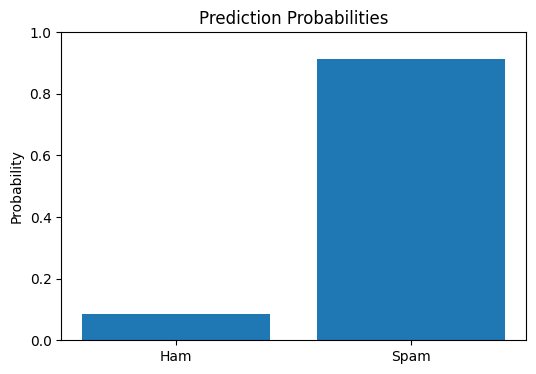

Prediction: Spam


In [17]:
message = "Congratulations! You've won a free lottery. Click here to claim now."
plot(message)

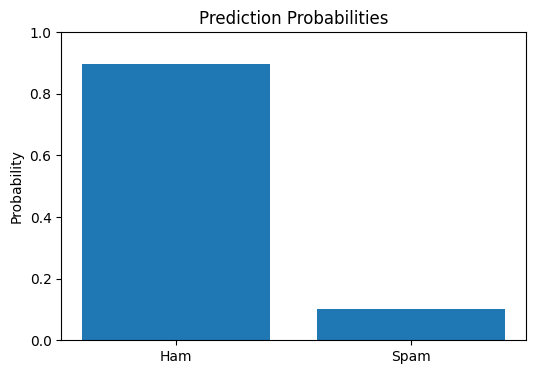

Prediction: Ham


In [18]:
message2 = "Hey Professor Cao, I forgot to do my homework today, sorry la!"
plot(message2)

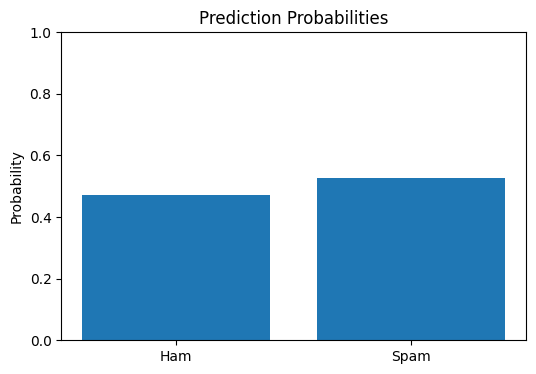

Prediction: Spam


In [19]:
message3 = "Hey Professor I forgot to do my homework today, BUT here is YOUR CHANCE to be a BIG SHOT! Call 114-514-1919810 claim NOW! "
plot(message3)

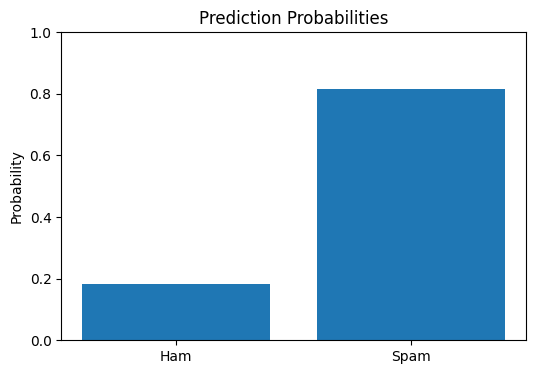

Prediction: Spam


In [20]:
message4 = "This is Amazon support. Due to security reasons, your account will be suspended unless you verify your identity immediately."
plot(message4)

# Sus Word Generation
Accuracy came first, human crosscheck with the dataset

TF-IDF -> Stopwords -> Base Keyword + Founded Keywords


In [217]:
base_keywords = [
    'win', 'winner', 'prize', 'claim', 'urgent', 'free', 'credit', 'offer',
    'congratulations', 'award', 'guaranteed', 'exclusive', 'bonus', 'cash',
    'immediately', 'limited', 'selected', 'click', 'unsubscribe', 'buy'
]

dangerous_roots = [
    'win', 'prize', 'urgent', 'claim', 'cash', 'free', 'credit', 'offer', 'bonus',
    'award', 'unsubscribe', 'buy', 'congratulations', 'lottery', 'reward', 'gift',
    'voucher', 'jackpot', 'selected', 'exclusive', 'deal', 'cashback', 'tinyurl'
]

In [218]:
spam_texts = df[df['label'] == 1]['text']

In [219]:
vectorizer = TfidfVectorizer(max_features=500)
X = vectorizer.fit_transform(spam_texts)

In [220]:
tfidf_scores = dict(zip(vectorizer.get_feature_names_out(), X.sum(axis=0).A1))

In [221]:
sorted_keywords = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)

In [222]:
stop_words = set(stopwords.words('english'))

In [223]:
filtered_keywords = []
for word, score in sorted_keywords:
    if (
        len(word) >= 3 and
        word not in stop_words and
        any(root in word for root in dangerous_roots)
    ):
        filtered_keywords.append(word)

In [224]:
final_keywords = list(set(base_keywords + filtered_keywords))

In [225]:
with open('model/sus_keywords.txt', 'w') as f:
    for word in final_keywords:
        f.write(f"{word}\n")


In [226]:
!cat model/sus_keywords.txt

limited
buy
gift
guaranteed
congratulations
cash
windows
free
winner
prize
selected
click
exclusive
win
following
credit
unsubscribe
tinyurl
immediately
wins
claim
urgent
bonus
offer
award
